In [21]:
import pandas as pd

# Model 1: User Features

In [12]:
import pandas as pd
import ast

def preprocess_user_data(df_users, df_label, df_tweets):
    # Step 1: Process 'public_metrics' column
    def public_metrics_col(df):
        col_names = list(ast.literal_eval(df['public_metrics'].iloc[0]).keys())
        final_cols = []
        for i in range(len(df)):
            dic = ast.literal_eval(df['public_metrics'].iloc[i])
            final_cols.append(list(dic.values()))
        metrics_df = pd.DataFrame(final_cols, columns=col_names)
        df = pd.concat([df.reset_index(drop=True), metrics_df], axis=1)
        return df
    
    # Apply the public_metrics_col function
    df_users = public_metrics_col(df_users)
    
    # Step 2: Create 'description_len' column
    df_users['description_len'] = df_users['description'].apply(lambda x: len(str(x)))
    
    # Step 3: Extract useful features
    useful_user_features = ["description_len", "id", "name", "protected", "followers_count", 
                            "following_count", "tweet_count", "listed_count", "username", "verified"]
    df_users_features = df_users[useful_user_features]
    
    # Step 4: Process label data
    df_label['tag'] = df_label['label'].apply(lambda x: 0 if x == "human" else 1)
    
    # Step 5: Filter df_users_features for users present in df_tweets
    users = list(df_tweets['author_id'].unique())
    users = set([str(i) for i in users])
    df_data = df_users_features[df_users_features['id'].isin(users)]
    df_data = df_data.reset_index(drop=True)
    
    # Step 6: Add 'label' column from df_label
    label_dict = dict(zip(df_label['id'], df_label['tag']))
    df_data['label'] = df_data['id'].apply(lambda x: label_dict[x])
    
    # Step 7: Convert 'protected' and 'verified' columns to binary
    df_data['protected'] = df_data['protected'].apply(lambda x: 1 if x == True else 0)
    df_data['verified'] = df_data['verified'].apply(lambda x: 1 if x == True else 0)
    
    # Step 8: Select relevant columns
    df_data = df_data[['description_len', 'protected', 'followers_count', 'following_count', 
                       'tweet_count', 'listed_count', 'verified', 'label', 'id']]
    
    return df_data



In [13]:
# Usage example
df_users = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/users.csv")
df_label = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/label.csv")
df_tweets = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_balanced.csv")


/var/folders/jr/zkdlkh_92dz8sgd8xw34xn7h0000gn/T/ipykernel_22367/401752804.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_users = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/users.csv")


In [14]:
data_clean = preprocess_user_data(df_users, df_label, df_tweets)

In [16]:
data_clean.to_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Users_balanced.csv", index = False)

In [17]:
data

,description_len,protected,followers_count,following_count,tweet_count,listed_count,verified,label,id
0,26,0,45541,1206,9194,605,0,1,u2465283662
1,44,0,26,121,4883,0,0,1,u864305332075364352
2,107,0,22642,2490,12436,190,0,0,u196278935
3,149,0,2532,2306,11674,36,0,0,u731478516181565440
4,159,0,1341,1979,1881,53,0,1,u35708687
...,...,...,...,...,...,...,...,...,...
93271,98,0,1354,1355,239,72,0,0,u18134480
93272,121,0,76,20,107,2,0,0,u706703037973147652
93273,174,0,1319,2691,35369,185,0,1,u22586384
93274,55,0,2426,430,264381,27,0,1,u747814153


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Load your data (make sure you've already loaded it into 'data')
# Example:
# data = pd.read_csv('your_data.csv')
data = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Users_balanced.csv")
# 2. Drop non-numeric or ID columns
try:
    data = data.drop(columns=['id']) 
except:
    pass # 'author_id' is just an identifier

# 4. Features and target
X = data.drop(columns=['label'])
y = data['label']

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Initialize and train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# 7. Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7573434819897084
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      9366
           1       0.75      0.77      0.76      9290

    accuracy                           0.76     18656
   macro avg       0.76      0.76      0.76     18656
weighted avg       0.76      0.76      0.76     18656



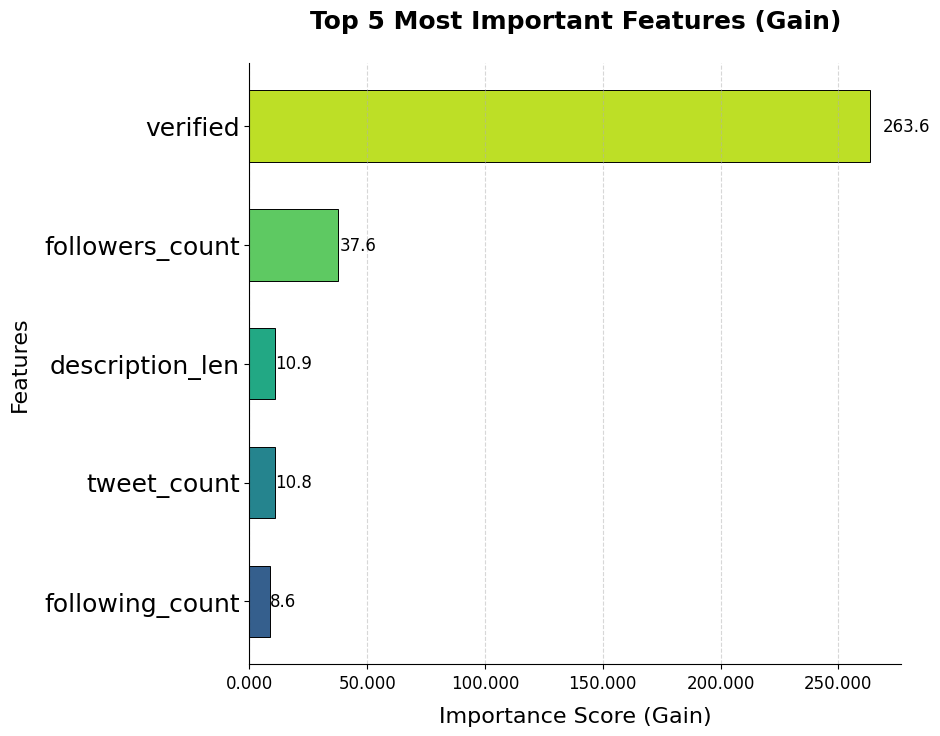

In [42]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib import cm

# Assuming model is already defined and trained (XGBClassifier)

# Get feature importance data
importance = model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*importance[:5])  # Get top 5 features

# Reverse the order to have most important on top
features = features[::-1]
scores = scores[::-1]

# Create a color gradient (now from bottom to top)
colors = cm.viridis(np.linspace(0.3, 0.9, len(features)))

# Create figure with larger size
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Create horizontal bar plot
bars = ax.barh(features, scores, color=colors, edgecolor='black', linewidth=0.7, height=0.6)

# Add value annotations with larger font
for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.02, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}',
            va='center', ha='left', fontsize=12)

# Styling with larger fonts
ax.set_title('Top 5 Most Important Features (Gain)', 
             fontsize=18, pad=25, fontweight='bold')
ax.set_xlabel('Importance Score (Gain)', fontsize=16, labelpad=10)
ax.set_ylabel('Features', fontsize=16, labelpad=10)

# Format x-axis with larger tick labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.3f}'))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=18)

# Custom grid style
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Remove spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Adjust layout with more padding
plt.tight_layout(pad=3)

# Show plot
plt.show()

# Model 2: Tweet Features

In [18]:
df0 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_Numerical_0.csv")
df2 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_Numerical_2.csv")
df6 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_Numerical_6.csv")


In [19]:
df = pd.concat([df0, df2, df6])

In [20]:
df['label'].value_counts()

label
human    520324
bot       50641
Name: count, dtype: int64

In [21]:
df_slice = df[df['tweet_count'] > 10]

In [22]:
df_slice['label'].value_counts()

label
human    380246
bot       38109
Name: count, dtype: int64

In [23]:
len(df['author_id'].unique())

467479

In [24]:
len(df)

570965

In [25]:
import pandas as pd

# Let's assume your DataFrame is called df

# Drop 'id' column
df = df.drop(columns=['id'])

# List of columns to apply tweet_count weighting
cols_to_weight = [
    'median_time_between_tweets_seconds', 'avg_retweet_count', 'avg_reply_count',
    'avg_like_count', 'avg_quote_count', 'avg_hashtag_count', 'avg_symbols_count',
    'avg_user_mentions_count', 'avg_media_count', 'avg_word_count',
    'median_time_between_tweets_minutes', 'median_time_between_tweets_hours'
]

# Multiply each column by tweet_count to prepare for weighted average
for col in cols_to_weight:
    df[col + '_weighted'] = df[col] * df['tweet_count']

# Group by author_id
grouped = df.groupby('author_id', as_index=False)

# Sum weighted columns and tweet_count
weighted_sums = grouped[[col + '_weighted' for col in cols_to_weight] + ['tweet_count']].sum()

# Calculate weighted averages
for col in cols_to_weight:
    weighted_sums[col] = weighted_sums[col + '_weighted'] / weighted_sums['tweet_count']

# Drop intermediate weighted columns
final_df = weighted_sums.drop(columns=[col + '_weighted' for col in cols_to_weight])

# Merge the label by taking first (or use .agg(lambda x: x.mode()[0]) if label is consistent)
labels = grouped['label'].first()

# Merge labels into final dataframe
final_df = final_df.merge(labels, on='author_id')

# final_df now contains the merged, weighted-average data per author_id


In [26]:
final_df['label'] = final_df['label'].replace({'human': 0, 'bot': 1})


/var/folders/jr/zkdlkh_92dz8sgd8xw34xn7h0000gn/T/ipykernel_17037/230283756.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['label'] = final_df['label'].replace({'human': 0, 'bot': 1})


In [27]:
final_df0 = final_df[final_df['label'] == 0]
final_df1 = final_df[final_df['label'] == 1]

In [32]:
final_df0_u = final_df0.sample(n=len(final_df1), random_state=42).reset_index(drop=True)

In [33]:

final_df_balanced = pd.concat([final_df1, final_df0_u])

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Load your data (make sure you've already loaded it into 'data')
# Example:
# data = pd.read_csv('your_data.csv')
data = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_balanced.csv")
data = data.rename(columns={'median_time_between_tweets_seconds': 'median_time'})
# 2. Drop non-numeric or ID columns
data = data.drop(columns=['author_id'])  # 'author_id' is just an identifier

# 4. Features and target
X = data.drop(columns=['label'])
y = data['label']

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Initialize and train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# 7. Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6605917667238422
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      9305
           1       0.65      0.69      0.67      9351

    accuracy                           0.66     18656
   macro avg       0.66      0.66      0.66     18656
weighted avg       0.66      0.66      0.66     18656



In [45]:
data.columns

Index(['tweet_count', 'median_time_between_tweets_seconds',
       'avg_retweet_count', 'avg_reply_count', 'avg_like_count',
       'avg_quote_count', 'avg_hashtag_count', 'avg_symbols_count',
       'avg_user_mentions_count', 'avg_media_count', 'avg_word_count',
       'median_time_between_tweets_minutes',
       'median_time_between_tweets_hours', 'label'],
      dtype='object')

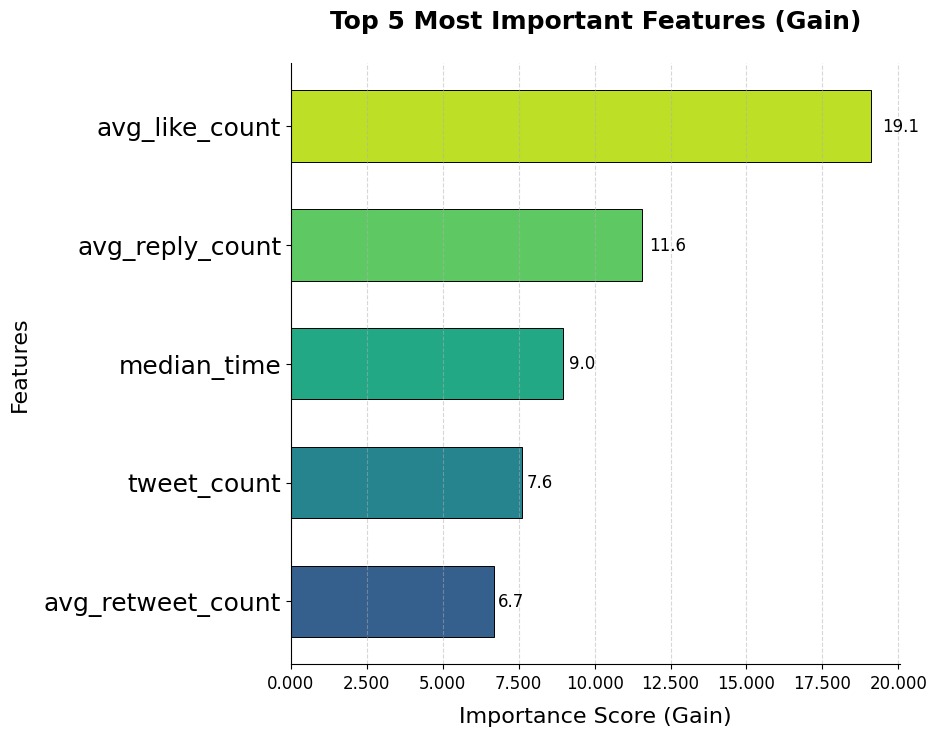

In [47]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib import cm

# Assuming model is already defined and trained (XGBClassifier)

# Get feature importance data
importance = model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*importance[:5])  # Get top 5 features

# Reverse the order to have most important on top
features = features[::-1]
scores = scores[::-1]

# Create a color gradient (now from bottom to top)
colors = cm.viridis(np.linspace(0.3, 0.9, len(features)))

# Create figure with larger size
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Create horizontal bar plot
bars = ax.barh(features, scores, color=colors, edgecolor='black', linewidth=0.7, height=0.6)

# Add value annotations with larger font
for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.02, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}',
            va='center', ha='left', fontsize=12)

# Styling with larger fonts
ax.set_title('Top 5 Most Important Features (Gain)', 
             fontsize=18, pad=25, fontweight='bold')
ax.set_xlabel('Importance Score (Gain)', fontsize=16, labelpad=10)
ax.set_ylabel('Features', fontsize=16, labelpad=10)

# Format x-axis with larger tick labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.3f}'))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=18)

# Custom grid style
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Remove spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Adjust layout with more padding
plt.tight_layout(pad=3)

# Show plot
plt.show()

# Model 3: User + Tweet

In [63]:
df_tu_0 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_User_Numerical_0.csv")
df_tu_2 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_User_Numerical_2.csv")
df_tu_6 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_User_Numerical_6.csv")

In [75]:
df_merged = pd.concat([df_tu_0, df_tu_2, df_tu_6])

In [ ]:
authors = final_df_balanced.author_id

In [103]:
df_merged = df_merged[df_merged['author_id'].isin(authors)]

In [104]:
import pandas as pd

df = df_merged.copy()

# Columns to weight by tweet_count_x
cols_to_weight = [
    'median_time_between_tweets_seconds', 'avg_retweet_count', 'avg_reply_count',
    'avg_like_count', 'avg_quote_count', 'avg_hashtag_count', 'avg_symbols_count',
    'avg_user_mentions_count', 'avg_media_count', 'avg_word_count',
    'median_time_between_tweets_minutes', 'median_time_between_tweets_hours'
]

# Multiply each column by tweet_count_x for weighted average
for col in cols_to_weight:
    df[col + '_weighted'] = df[col] * df['tweet_count_x']

# Group by author_id
grouped = df.groupby('author_id', as_index=False)

# Sum weighted columns and tweet_count_x
weighted_sums = grouped[[col + '_weighted' for col in cols_to_weight] + ['tweet_count_x']].sum()

# Compute weighted averages
for col in cols_to_weight:
    weighted_sums[col] = weighted_sums[col + '_weighted'] / weighted_sums['tweet_count_x']

# Drop the intermediate weighted columns
weighted_sums.drop(columns=[col + '_weighted' for col in cols_to_weight], inplace=True)

# Now get first value of all other columns (excluding ones we've already aggregated)
columns_to_take_first = [
    col for col in df.columns
    if col not in cols_to_weight and not col.endswith('_weighted') and col != 'tweet_count_x'
]

first_vals = grouped[columns_to_take_first].first()

# Merge weighted averages with first-value columns
final_df = pd.merge(weighted_sums, first_vals, on='author_id', how='left')


In [105]:
final_df = final_df.drop(columns=['author_id', 'id_x', 'id_y'])

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Load your data (make sure you've already loaded it into 'data')
# Example:
# data = pd.read_csv('your_data.csv')
data = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_Users_Balanced.csv")
# 2. Drop non-numeric or ID columns
# data = data.drop(columns=['author_id'])  # 'author_id' is just an identifier

# 4. Features and target
X = data.drop(columns=['label'])
y = data['label']

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Initialize and train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# 7. Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7666166380789022
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      9423
           1       0.77      0.76      0.76      9233

    accuracy                           0.77     18656
   macro avg       0.77      0.77      0.77     18656
weighted avg       0.77      0.77      0.77     18656



In [107]:
final_df['label'].value_counts()

label
0    46638
1    46638
Name: count, dtype: int64

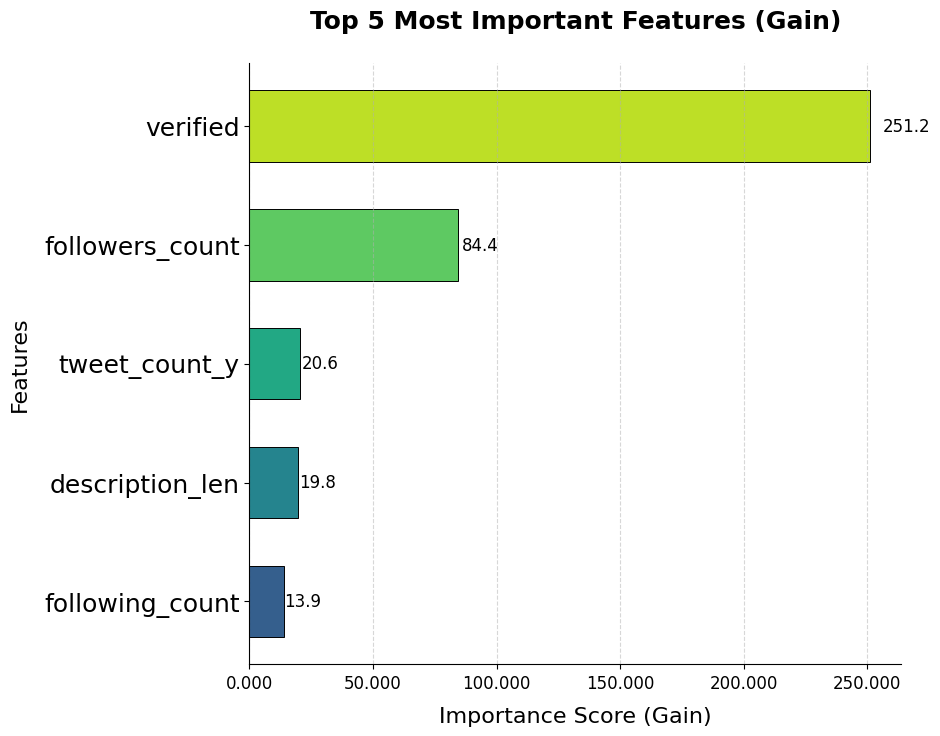

In [52]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib import cm

# Assuming model is already defined and trained (XGBClassifier)

# Get feature importance data
importance = model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*importance[:5])  # Get top 5 features

# Reverse the order to have most important on top
features = features[::-1]
scores = scores[::-1]

# Create a color gradient (now from bottom to top)
colors = cm.viridis(np.linspace(0.3, 0.9, len(features)))

# Create figure with larger size
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Create horizontal bar plot
bars = ax.barh(features, scores, color=colors, edgecolor='black', linewidth=0.7, height=0.6)

# Add value annotations with larger font
for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.02, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}',
            va='center', ha='left', fontsize=12)

# Styling with larger fonts
ax.set_title('Top 5 Most Important Features (Gain)', 
             fontsize=18, pad=25, fontweight='bold')
ax.set_xlabel('Importance Score (Gain)', fontsize=16, labelpad=10)
ax.set_ylabel('Features', fontsize=16, labelpad=10)

# Format x-axis with larger tick labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.3f}'))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=18)

# Custom grid style
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Remove spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Adjust layout with more padding
plt.tight_layout(pad=3)

# Show plot
plt.show()

In [116]:
final_df.to_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_Users_Balanced.csv", index = False)

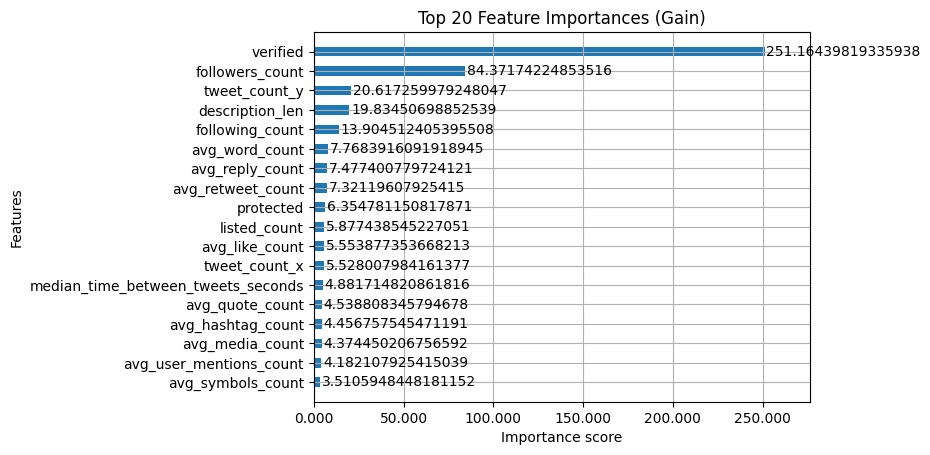

In [121]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming model is already defined and trained

# Plot feature importances
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)

# Get current axis
ax = plt.gca()

# Format ticks on the x-axis to show only 3 decimal places
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.3f}'))

plt.title('Top 20 Feature Importances (Gain)')
plt.show()


In [18]:
import pandas as pd

In [19]:
df = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_balanced.csv")

In [20]:
df.columns

Index(['author_id', 'tweet_count', 'median_time_between_tweets_seconds',
       'avg_retweet_count', 'avg_reply_count', 'avg_like_count',
       'avg_quote_count', 'avg_hashtag_count', 'avg_symbols_count',
       'avg_user_mentions_count', 'avg_media_count', 'avg_word_count',
       'median_time_between_tweets_minutes',
       'median_time_between_tweets_hours', 'label'],
      dtype='object')